### Imports

In [1]:
from nltk.corpus import movie_reviews as reviews
from sklearn.datasets import fetch_20newsgroups
from gensim.models import KeyedVectors
from gensim.models import word2vec

import wget
import numpy as np
import pandas as pd
import re
import datetime
from operator import itemgetter
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt

import os
import time
import string
import dill
import pickle
import gzip

from nltk import *
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
from nltk.stem.snowball import SnowballStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report as clsr
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split as tts
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, SpatialDropout1D, Activation, Conv1D, MaxPooling1D, Input, concatenate
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### Data retrieving

In [15]:
# Load from .csv file with complete dataset
data_essays = pd.read_csv('./Data/essays.csv', encoding = "ISO-8859-1")
data_essays['cEXT'] = np.where(data_essays['cEXT']=='y', 1, 0)
data_essays['cNEU'] = np.where(data_essays['cNEU']=='y', 1, 0)
data_essays['cAGR'] = np.where(data_essays['cAGR']=='y', 1, 0)
data_essays['cCON'] = np.where(data_essays['cCON']=='y', 1, 0)
data_essays['cOPN'] = np.where(data_essays['cOPN']=='y', 1, 0)
X_essays = data_essays['TEXT'].tolist()
y_essays = data_essays[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]
data_essays['text length'] = data_essays['TEXT'].apply(len)
labels = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
X_train, X_test, y_train, y_test = tts(X_essays, y_essays, test_size=0.2)

In [11]:
# Train-test split to save the dataset
with open('./Data/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('./Data/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('./Data/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('./Data/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
# Load train and test sets from pickled lists
with open('./Data/X_train.pkl', 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)
with open('./Data/X_test.pkl', 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)
with open('./Data/y_train.pkl', 'rb') as pickle_file:
    y_train = pickle.load(pickle_file)
with open('./Data/y_test.pkl', 'rb') as pickle_file:
    y_test = pickle.load(pickle_file)

### Visualization

In [87]:
import random
class visualize:

    def __init__(self, complete_dataset, X, labels_list):
        self.data = complete_dataset
        self.X = X
        self.labels_list = labels_list

    def textlength_vs_labels_histogram(self):
        # Visualization of histograms of text length vs. label
        for label in self.labels_list:
            g = sns.FacetGrid(data=self.data, col=label)
            g.map(plt.hist, 'text length', bins=50)
        plt.show()

    def textlength_vs_labels_boxplot(self):
        # Visualization of boxplots of text length vs. label
        for i, label in enumerate(self.labels_list):
            plt.figure(i)
            sns.boxplot(x=label, y='text length', data=self.data)
        plt.show()

    def most_frequent_words(self):
        # Visualization of the most frequent words
        complete_corpus = ' '.join(self.X)
        words = tokenize.word_tokenize(complete_corpus)
        fdist = FreqDist(words)
        print("List of 100 most frequent words/counts")
        print(fdist.most_common(100))
        fdist.plot(40)

    def most_frequent_words_preprocessed(self):
        # Visualization of the most frequent words
        if not hasattr(self, 'X_preprocess'):
            preprocessor = train(corpus = self.X).NLTKPreprocessor
            self.X_preprocess = prep.transform(self.X).tolist()
        complete_corpus = ' '.join(self.X_preprocess)
        words = tokenize.word_tokenize(complete_corpus)
        fdist = FreqDist(words)
        print("List of 100 most frequent words/counts")
        print(fdist.most_common(100))
        fdist.plot(40)

    def get_corpus_statistics(self):
        # Retrieve some info on the text data
        numWords = []
        for text in self.X:
                counter = len(text.split())
                numWords.append(counter)  
        numFiles = len(numWords)
        print('The total number of essays is', numFiles)
        print('The total number of words in all essays is', sum(numWords))
        print('The average number of words in each essay is', sum(numWords)/len(numWords))

    def get_preprocessed_corpus_statistics(self):
        # Retrieve some info on the preprocessed text data
        if not hasattr(self, 'X_preprocess'):
            preprocessor = train(corpus = self.X).NLTKPreprocessor
            self.X_preprocess = prep.transform(self.X).tolist()
        len_list = [np.count_nonzero(self.X_preprocess[i]) for i in range(len(self.X))]
        print('The average number of words in each preprocessed essay is', np.mean(len_list))
        print('The standard deviation of the number of words in each preprocessed essay is', np.std(len_list))
        print('The average number of words in each preprocessed essay plus 2 standard deviations is', np.mean(len_list) + 2 * np.std(len_list))

class tsne:
    
    def __init__(self, X, max_features = 30000, max_sentence_len = 300, embed_dim = 300,  n_elements = 100):
        self.X = X
        self.max_features =max_features
        self.max_sentence_len = max_sentence_len
        self.embed_dim = embed_dim
        self.n_elements = n_elements
        self.vectors, self.words, self.dic =  self.prepare_embedding(self.X)

    def load_google_vec(self):
        url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
        #wget.download(url, 'Data/GoogleNews-vectors.bin.gz')
        return KeyedVectors.load_word2vec_format(
            'Data/GoogleNews-vectors.bin.gz',
            binary=True)

    def lemmatize_token(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)


    def get_preprocessed_corpus(self, X_corpus):
        """
        Returns a preprocessed version of a full corpus (ie. tokenization and lemmatization using POS taggs)
        """
        X = ' '.join(X_corpus)
        lemmatized_tokens = []

        # Break the document into sentences
        for sent in sent_tokenize(X):

            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):

                # Apply preprocessing to the token
                token = token.lower()
                token = token.strip()
                token = token.strip('_')
                token = token.strip('*')

                # If punctuation or stopword, ignore token and continue
                if token in set(sw.words('english')) or all(char in set(string.punctuation) for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize_token(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        return doc


    def prepare_embedding(self, X):
        """
        Returns the embedding weights matrix, the word index, and the word-vector dictionnary corresponding
        to the training corpus set of words.
        """
        # Load Word2Vec vectors
        word2vec = self.load_google_vec()

        # Fit and apply an NLTK tokenizer on the preprocessed training corpus to obtain sequences.
        tokenizer = Tokenizer(num_words=self.max_features)
        X_pad = self.get_preprocessed_corpus(X)
        tokenizer.fit_on_texts(pd.Series(X_pad))
        X_pad = tokenizer.texts_to_sequences(pd.Series(X_pad))

        # Pad the sequences
        X_pad = pad_sequences(X_pad, maxlen=self.max_sentence_len, padding='post', truncating='post')

        # Retrieve the word index
        train_word_index = tokenizer.word_index

        # Construct the embedding weights matrix and word-vector dictionnary
        train_embedding_weights = np.zeros((len(train_word_index) + 1, self.embed_dim))
        for word, index in train_word_index.items():
            train_embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(self.embed_dim)
        word_vector_dict = dict(zip(pd.Series(list(train_word_index.keys())),
                                    pd.Series(list(train_word_index.keys())).apply(
                                        lambda x: train_embedding_weights[train_word_index[x]])))
        return train_embedding_weights, train_word_index, word_vector_dict


    def plot(self):
        labels = []
        tokens = []

        l_bound = 0
        u_bound = len(self.words)
        step = int(len(self.words)/self.n_elements)

        #for index in range(l_bound,u_bound, step):
        for index in random.sample(range(l_bound,u_bound), self.n_elements):
            tokens.append(self.vectors[index])
            labels.append(self.words[index])

        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
        new_values = tsne_model.fit_transform(tokens)

        xx = []
        yy = []
        for value in new_values:
            xx.append(value[0])
            yy.append(value[1])

        plt.figure(figsize=(16, 16))
        for i in range(len(xx)):
            plt.scatter(xx[i],yy[i])
            plt.annotate(labels[i],
                         xy=(xx[i], yy[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
        plt.show()


class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
    """

    def __init__(self, corpus, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
        """
        Instantiates the preprocessor.
        """
        self.lower = lower
        self.strip = strip
        self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
        self.punct = set(punct) if punct else set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.corpus = corpus
        self.max_sentence_len = max_sentence_len

    def fit(self, X, y=None):
        """
        Fit simply returns self.
        """
        return self

    def inverse_transform(self, X):
        """
        No inverse transformation.
        """
        return X

    def transform(self, X):
        """
        Actually runs the preprocessing on each document.
        """
        output = np.array([(self.tokenize(doc)) for doc in X])
        return output

    def tokenize(self, document):
        """
        Returns a normalized, lemmatized list of tokens from a document by
        applying segmentation, tokenization, and part of speech tagging.
        Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
        version of all the words, removing stopwords and punctuation.
        """
        lemmatized_tokens = []

        # Clean the text
        document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
        document = re.sub(r"what's", "what is ", document)
        document = re.sub(r"\'s", " ", document)
        document = re.sub(r"\'ve", " have ", document)
        document = re.sub(r"can't", "cannot ", document)
        document = re.sub(r"n't", " not ", document)
        document = re.sub(r"i'm", "i am ", document)
        document = re.sub(r"\'re", " are ", document)
        document = re.sub(r"\'d", " would ", document)
        document = re.sub(r"\'ll", " will ", document)
        document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

        # Break the document into sentences
        for sent in sent_tokenize(document):

            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):

                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token):
                    continue

                # Lemmatize the token
                lemma = self.lemmatize(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
        return tokenized_document


    def vectorize(self, doc):
        """
        Returns a vectorized padded version of sequences.
        """
        save_path = "Data/padding.pickle"
        with open(save_path, 'rb') as f:
            tokenizer = pickle.load(f)
        doc_pad = tokenizer.texts_to_sequences(doc)
        doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
        return np.squeeze(doc_pad)

    def lemmatize(self, token, tag):
        """
        Converts the Penn Treebank tag to a WordNet POS tag, then uses that
        tag to perform WordNet lemmatization.
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)


##### Histograms of text length distrbution for the different labels

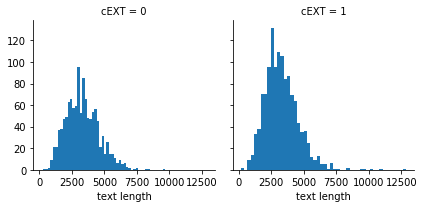

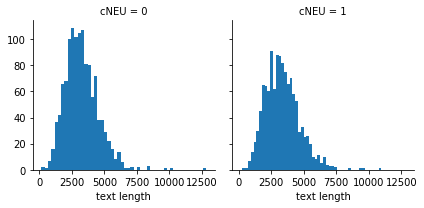

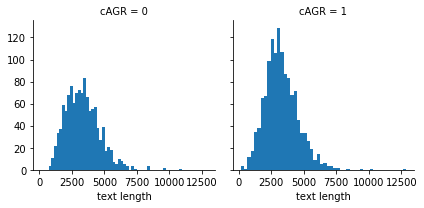

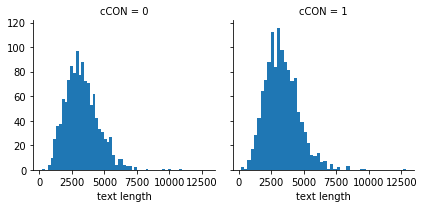

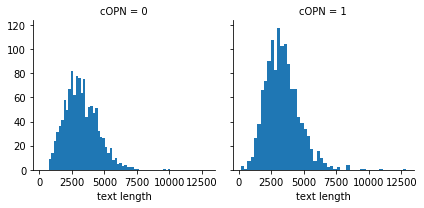

In [89]:
viz = visualize(data_essays, X_essays, labels)
viz.textlength_vs_labels_histogram()

##### Boxplots of text length distrbution for the different labels

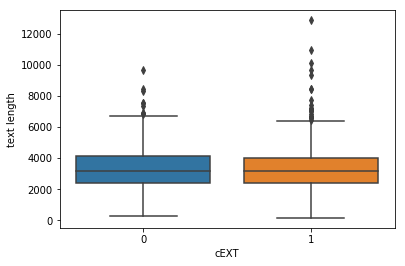

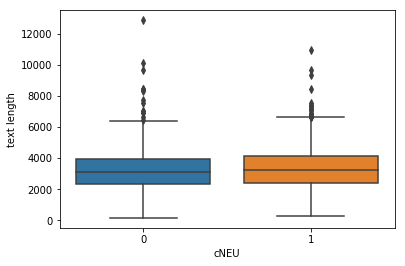

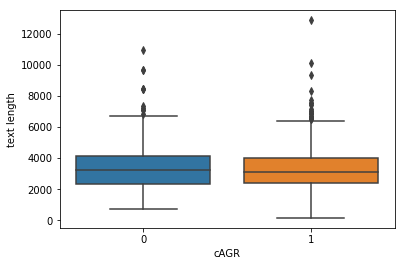

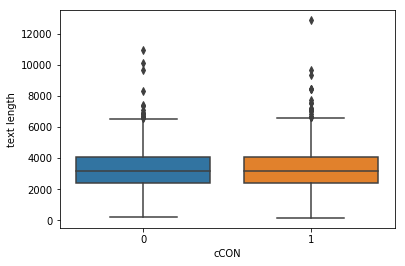

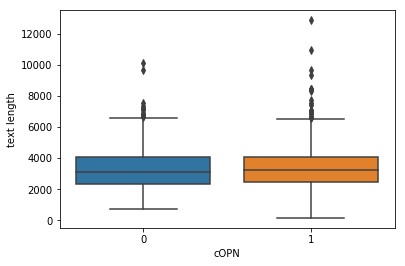

In [90]:
viz.textlength_vs_labels_boxplot()

##### Most frequent words in the corpus

List of 100 most frequent words/counts
[('I', 115468), ('.', 111178), ('to', 56263), (',', 47355), ('the', 38232), ('and', 36810), ('that', 29456), ('a', 28408), ('my', 26580), ('is', 25576), ('of', 22939), ('it', 22781), ("n't", 19996), ('in', 17828), ('do', 17448), ('have', 16166), ('me', 14588), ('so', 13099), ('but', 13060), ('this', 12054), ('be', 11724), ('for', 11520), ("'s", 11198), ('was', 10392), ('am', 10378), ('like', 10308), ('just', 10250), ('really', 10207), ('not', 10015), ("'m", 9973), ('on', 9015), ('about', 8941), ('with', 8708), ('think', 8061), ('are', 7602), ('what', 7517), ('all', 7475), ('at', 7469), ('because', 7144), ('i', 7047), ('know', 6959), ('get', 6875), ('he', 6605), ('now', 6154), ('would', 6077), ('you', 6013), ('if', 6001), ('time', 5966), ('out', 5923), ('they', 5905), ('up', 5743), ('or', 5733), ('going', 5621), ('go', 5576), ('she', 5556), ('?', 5539), ('want', 5483), ('will', 5420), ('can', 5276), ('!', 4959), ('as', 4939), ('people', 4898), ('he

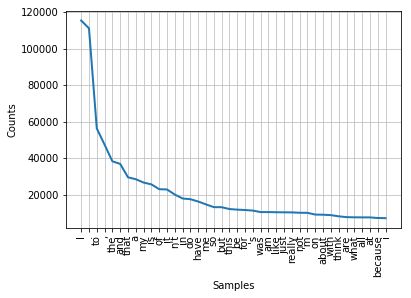

In [91]:
viz.most_frequent_words()

##### Most frequent words in the preprocessed corpus

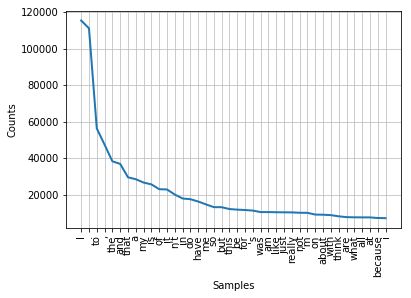

In [7]:
viz.most_frequent_words_preprocessed()

##### Statistics on the text corpus

In [92]:
viz.get_corpus_statistics()

The total number of essays is 2467
The total number of words in all essays is 1608813
The average number of words in each essay is 652.1333603567085


In [37]:
viz.get_preprocessed_corpus_statistics()

The average number of words in each preprocessed essay is 167.26509931090393
The standard deviation of the number of words in each preprocessed essay is 62.85333564580388
The average number of words in each preprocessed essay plus 2 standard deviations is 292.9717706025117


In [88]:
viz_tsne = tsne(X_essays, max_features = 30000, max_sentence_len = 300, embed_dim = 300,  n_elements = 100)
viz_tsne.plot()

KeyError: 8791

### Train models

#### Train Keras model

In [76]:
class train:

    def __init__(self, corpus):
        self.max_sentence_len = 300
        self.max_features = 300
        self.embed_dim = 300
        self.lstm_out = 180
        self.dropout_lstm = 0.3
        self.recurrent_dropout_lstm = 0.3
        self.dropout = 0.3
        self.conv_nfilters = 128
        self.conv_kernel_size = 8
        self.max_pool_size = 2
        self.NLTKPreprocessor = self.NLTKPreprocessor(corpus)
        #self.MyRNNTransformer = self.MyRNNTransformer()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, corpus, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.corpus = corpus
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "./Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 135
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.classes


    def multiclass_accuracy(self,predictions, target):
        "Returns the multiclass accuracy of the classifier's predictions"
        score = []
        for j in range(0, 5):
            count = 0
            for i in range(len(predictions)):
                if predictions[i][j] == target[i][j]:
                    count += 1
            score.append(count / len(predictions))
        return score


    def load_google_vec(self):
        url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
        #wget.download(url, 'Data/GoogleNews-vectors.bin.gz')
        return KeyedVectors.load_word2vec_format(
            'Data/GoogleNews-vectors.bin.gz',
            binary=True)

    def lemmatize_token(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)


    def get_preprocessed_corpus(self, X_corpus):
        """
        Returns a preprocessed version of a full corpus (ie. tokenization and lemmatization using POS taggs)
        """
        X = ' '.join(X_corpus)
        lemmatized_tokens = []

        # Break the document into sentences
        for sent in sent_tokenize(X):

            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):

                # Apply preprocessing to the token
                token = token.lower()
                token = token.strip()
                token = token.strip('_')
                token = token.strip('*')

                # If punctuation or stopword, ignore token and continue
                if token in set(sw.words('english')) or all(char in set(string.punctuation) for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize_token(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        return doc


    def prepare_embedding(self, X):
        """
        Returns the embedding weights matrix, the word index, and the word-vector dictionnary corresponding
        to the training corpus set of words.
        """
        # Load Word2Vec vectors
        word2vec = self.load_google_vec()

        # Fit and apply an NLTK tokenizer on the preprocessed training corpus to obtain sequences.
        tokenizer = Tokenizer(num_words=self.max_features)
        X_pad = self.get_preprocessed_corpus(X)
        tokenizer.fit_on_texts(pd.Series(X_pad))
        X_pad = tokenizer.texts_to_sequences(pd.Series(X_pad))

        # Pad the sequences
        X_pad = pad_sequences(X_pad, maxlen=self.max_sentence_len, padding='post', truncating='post')

        # Retrieve the word index
        train_word_index = tokenizer.word_index

        # Construct the embedding weights matrix and word-vector dictionnary
        train_embedding_weights = np.zeros((len(train_word_index) + 1, self.embed_dim))
        for word, index in train_word_index.items():
            train_embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(self.embed_dim)
        word_vector_dict = dict(zip(pd.Series(list(train_word_index.keys())),
                                    pd.Series(list(train_word_index.keys())).apply(
                                        lambda x: train_embedding_weights[train_word_index[x]])))
        return train_embedding_weights, train_word_index, word_vector_dict


    def run(self, X, y, model_name=None, pretrained_weights_path = None, pretrained_model_path = None, verbose=True):
        """
        Builds a classifer for the given list of documents and targets

        """

        def build(classifier, X, y, embedding_dict, corpus):
            """
            Inner build function that builds a pipeline including a preprocessor and a classifier.
            """
            model = Pipeline([
                ('preprocessor', self.NLTKPreprocessor),
                ('classifier', classifier)
            ])
            return model.fit(X, y)

        # Label encode the targets
        y_trans = y

        # Prepare the embedding
        train_embedding_weights, train_word_index, wv_dict = self.prepare_embedding(X)

        # Begin evaluation
        if verbose: print("Building for evaluation")
        indices = range(len(y))

        # Keras model definition
        Input_words = Input(shape=(300,), name='input1')
        x = Embedding(len(train_word_index) + 1, self.embed_dim, weights=[train_embedding_weights],
                      input_length=self.max_sentence_len, trainable=True)(Input_words)
        # classifier.add(Embedding(30000, 300,input_length = 350))
        x = Conv1D(filters=self.conv_nfilters, kernel_size= self.conv_kernel_size, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=self.max_pool_size)(x)
        x = SpatialDropout1D(self.dropout)(x)
        x = BatchNormalization()(x)
        x = Conv1D(filters=(self.conv_nfilters)*2, kernel_size= self.conv_kernel_size, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=self.max_pool_size)(x)
        x = SpatialDropout1D(self.dropout)(x)
        x = BatchNormalization()(x)
        x = Conv1D(filters=(self.conv_nfilters)*3, kernel_size= self.conv_kernel_size, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=self.max_pool_size)(x)
        x = SpatialDropout1D(self.dropout)(x)
        x = BatchNormalization()(x)
        x = LSTM(self.lstm_out, return_sequences=True, dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout_lstm)(x)
        x = LSTM(self.lstm_out, return_sequences=True, dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout_lstm)(x)
        x = LSTM(self.lstm_out, dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout_lstm)(x)
        x = Dense(128, activation='softmax')(x)
        out = Dense(5, activation='softmax')(x)
        classifier = Model(inputs=Input_words, outputs=[out])
        classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(classifier.summary())

        # Loading pretrained model for transfer learning
        if pretrained_weights_path and pretrained_model_path:
            json_file = open(pretrained_model_path, 'r')
            classifier = model_from_json(json_file.read())
            classifier.load_weights(pretrained_weights_path)
            classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            json_file.close()
            model = build(self.MyRNNTransformer(classifier), X, y_trans, wv_dict, corpus=X)
            
        # Train on the whole set from scratch
        if verbose: 
            print("Building complete model and saving ...")
            model= build(self.MyRNNTransformer(classifier), X, y_trans, wv_dict, corpus=X)

        # Save the model
        if model_name:
            outpath = './Models/'
            classifier.save_weights(outpath + model_name + '.h5')
            with open(outpath + model_name + '.json', 'w') as json_file:
                json_file.write(classifier.to_json())
            print("Model written out to {}".format(model_name))
        else:
            print('Please provide model name for saving')
        
        return model



In [77]:
model = train(X_train).run(X_train, y_train, "Personality_traits_NN")

Building for evaluation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 300, 300)          6704100   
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 300, 128)          307328    
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 150, 128)          0         
_________________________________________________________________
spatial_dropout1d_38 (Spatia (None, 150, 128)          0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 150, 128)          512       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 150, 256)       

Epoch 109/135
 - 31s - loss: 3.5640 - acc: 0.2255
Epoch 110/135
 - 31s - loss: 3.5813 - acc: 0.2357
Epoch 111/135
 - 31s - loss: 3.5756 - acc: 0.2286
Epoch 112/135
 - 31s - loss: 3.5669 - acc: 0.2321
Epoch 113/135
 - 32s - loss: 3.5592 - acc: 0.2342
Epoch 114/135
 - 31s - loss: 3.5553 - acc: 0.2494
Epoch 115/135
 - 31s - loss: 3.5499 - acc: 0.2402
Epoch 116/135
 - 31s - loss: 3.5548 - acc: 0.2342
Epoch 117/135
 - 31s - loss: 3.5595 - acc: 0.2438
Epoch 118/135
 - 31s - loss: 3.5493 - acc: 0.2321
Epoch 119/135
 - 31s - loss: 3.5516 - acc: 0.2478
Epoch 120/135
 - 31s - loss: 3.5398 - acc: 0.2443
Epoch 121/135
 - 31s - loss: 3.5323 - acc: 0.2544
Epoch 122/135
 - 31s - loss: 3.5171 - acc: 0.2712
Epoch 123/135
 - 31s - loss: 3.5237 - acc: 0.2509
Epoch 124/135
 - 31s - loss: 3.5163 - acc: 0.2514
Epoch 125/135
 - 31s - loss: 3.5018 - acc: 0.2539
Epoch 126/135
 - 31s - loss: 3.5033 - acc: 0.2408
Epoch 127/135
 - 31s - loss: 3.4943 - acc: 0.2499
Epoch 128/135
 - 31s - loss: 3.4912 - acc: 0.2549


#### Train SVM

In [91]:
class train_svm:

    def __init__(self, corpus):
        self.max_sentence_len = 300
        self.max_features = 300
        self.embed_dim = 300
        self.NLTKPreprocessor = self.NLTKPreprocessor(corpus)
        #self.MyRNNTransformer = self.MyRNNTransformer()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, corpus, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.corpus = corpus
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "./Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 35
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict_proba(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.classes


    class TfidfEmbeddingVectorizer(object):
        def __init__(self, word2vec):
            self.word2vec = word2vec
            self.word2weight = None
            self.dim = len(word2vec.values())

        def fit(self, X, y):
            tfidf = TfidfVectorizer(analyzer=lambda x: x)
            tfidf.fit(X)
            # if a word was never seen - it must be at least as infrequent
            # as any of the known words. So the default idf is the max of
            # known idf's
            max_idf = max(tfidf.idf_)
            self.word2weight = defaultdict(
                lambda: max_idf,
                [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

            return self

        def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


    def identity(self, arg):
        """
        Simple identity function works as a passthrough.
        """
        return arg


    def reshape_a_feature_column(self, series):
        return np.reshape(np.asarray(series), (len(series), 1))


    def pipelinize_feature(self, function, active=True):
        def list_comprehend_a_function(list_or_series, active=True):
            if active:
                processed = [function(i) for i in list_or_series]
                processed = self.reshape_a_feature_column(processed)
                return processed
            else:
                return self.reshape_a_feature_column(np.zeros(len(list_or_series)))


    def get_text_length(self, text):
        return len(text)

    def load_google_vec(self):
        #url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
        #wget.download(url, 'Data/GoogleNews-vectors.bin.gz')
        return KeyedVectors.load_word2vec_format(
            'Data/GoogleNews-vectors.bin.gz',
            binary=True)


    def lemmatize_token(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)


    def get_preprocessed_corpus(self, X_corpus):
        """
        Returns a preprocessed version of a full corpus (ie. tokenization and lemmatization using POS taggs)
        """
        X = ' '.join(X_corpus)
        lemmatized_tokens = []

        # Break the document into sentences
        for sent in sent_tokenize(X):

            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):

                # Apply preprocessing to the token
                token = token.lower()
                token = token.strip()
                token = token.strip('_')
                token = token.strip('*')

                # If punctuation or stopword, ignore token and continue
                if token in set(sw.words('english')) or all(char in set(string.punctuation) for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize_token(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        return doc


    def prepare_embedding(self, X):
        """
        Returns the embedding weights matrix, the word index, and the word-vector dictionnary corresponding
        to the training corpus set of words.
        """
        # Load Word2Vec vectors
        word2vec = self.load_google_vec()

        # Fit and apply an NLTK tokenizer on the preprocessed training corpus to obtain sequences.
        tokenizer = Tokenizer(num_words=self.max_features)
        X_pad = self.get_preprocessed_corpus(X)
        tokenizer.fit_on_texts(pd.Series(X_pad))
        X_pad = tokenizer.texts_to_sequences(pd.Series(X_pad))

        # Pad the sequences
        X_pad = pad_sequences(X_pad, maxlen=self.max_sentence_len, padding='post', truncating='post')

        # Retrieve the word index
        train_word_index = tokenizer.word_index

        # Construct the embedding weights matrix and word-vector dictionnary
        train_embedding_weights = np.zeros((len(train_word_index) + 1, self.embed_dim))
        for word, index in train_word_index.items():
            train_embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(self.embed_dim)
        word_vector_dict = dict(zip(pd.Series(list(train_word_index.keys())),
                                    pd.Series(list(train_word_index.keys())).apply(
                                        lambda x: train_embedding_weights[train_word_index[x]])))
        return train_embedding_weights, train_word_index, word_vector_dict



    def multiclass_accuracy(self,predictions, target):
        "Returns the multiclass accuracy of the classifier's predictions"
        score = []
        for j in range(0, 5):
            count = 0
            for i in range(len(predictions)):
                if predictions[i][j] == target[i][j]:
                    count += 1
            score.append(count / len(predictions))
        return score


    def run(self,X, y, classifier=SGDClassifier, model_name=None,
                           verbose=True):
        """
        Builds a classifer for the given list of documents and targets
        """
        def build(classifier, X, y, embedding_dict, corpus):
            """
            Inner build function that builds a single model.
            """
            classifier = OneVsRestClassifier(classifier(loss = "modified_huber", alpha=0.00000001), n_jobs=-1)
            model = Pipeline([
                ('preprocessor', self.NLTKPreprocessor),
                ("wordVectz", self.TfidfEmbeddingVectorizer(embedding_dict)),
                ('clf', classifier)
            ])
            return model.fit(X, y)

        y_trans = y

        # Prepare the embedding
        train_embedding_weights, train_word_index, wv_dict = self.prepare_embedding(X)

        # Begin evaluation
        if verbose: print("Building complete model and saving ...")
        model = build(classifier, X, y_trans, wv_dict, corpus=X)
        
        # Save the model
        if model_name:
            outpath = 'Models/'
            with open(outpath + model_name, 'wb') as f:
                dill.dump(model, f)
            print("Model written out to {}".format(model_name))

        return model


In [92]:
model = train_svm(X_train).run(X_train, y_train, model_name = "Personality_traits_SVM")

Building complete model and saving ...
Model written out to Personality_traits_SVM


### Test models

#### Test Keras model

In [9]:
class test:

    def __init__(self):
        self.max_sentence_len = 300
        self.max_features = 300
        self.embed_dim = 300
        self.NLTKPreprocessor = self.NLTKPreprocessor()
        #self.MyRNNTransformer = self.MyRNNTransformer()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "./Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 35
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.pred

    def multiclass_accuracy(self,predictions, target):
        "Returns the multiclass accuracy of the classifier's predictions"
        score = []
        for j in range(0, 5):
            count = 0
            for i in range(len(predictions)):
                if predictions[i][j] == target[i][j]:
                    count += 1
            score.append(count / len(predictions))
        return score


    def run(self, X, y, model_name):
        """
        Returns the predictions from the pipeline including our NLTKPreprocessor and Keras classifier.
        """
        def build(classifier):
            """
            Inner build function that builds a pipeline including a preprocessor and a classifier.
            """
            model = Pipeline([
                    ('preprocessor', self.NLTKPreprocessor),
                    ('classifier', classifier)
                ])
            return model

        save_path = './Models/'
        json_file = open(save_path + model_name + '.json', 'r')
        classifier = model_from_json(json_file.read())
        classifier.load_weights(save_path + model_name + '.h5')
        classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        json_file.close()
        model = build(self.MyRNNTransformer(classifier))
        y_pred = model.transform(X)
        y_pred_classes = [[0 if el < 0.2 else 1 for el in item] for item in y_pred]
        print(self.multiclass_accuracy(y.values.tolist(), y_pred_classes))

        return y_pred

In [10]:
pred = test().run(X_test, y_test, model_name = "Personality_traits_NN")

[0.6437246963562753, 0.771255060728745, 0.7125506072874493, 0.8117408906882592, 0.8502024291497976]


#### Test SVM

In [93]:
class test_svm:

    def __init__(self):
        self.max_sentence_len = 300
        self.NLTKPreprocessor = self.NLTKPreprocessor()
        #self.MyRNNTransformer = self.MyRNNTransformer()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "./Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 35
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict_proba(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.pred


    def identity(self, arg):
        """
        Simple identity function works as a passthrough.
        """
        return arg


    def reshape_a_feature_column(self, series):
        return np.reshape(np.asarray(series), (len(series), 1))


    def pipelinize_feature(self, function, active=True):
        def list_comprehend_a_function(list_or_series, active=True):
            if active:
                processed = [function(i) for i in list_or_series]
                processed = self.reshape_a_feature_column(processed)
                return processed
            else:
                return self.reshape_a_feature_column(np.zeros(len(list_or_series)))


    def get_text_length(self, text):
        return len(text)


    def multiclass_accuracy(self,predictions, target):
        "Returns the multiclass accuracy of the classifier's predictions"
        score = []
        for j in range(0, 5):
            count = 0
            for i in range(len(predictions)):
                if predictions[i][j] == target[i][j]:
                    count += 1
            score.append(count / len(predictions))
        return score


    def run(self, X, y, model_name):
        """
        Returns the predictions from the pipeline including our NLTKPreprocessor and SVM classifier.
        """
        save_path = "./Models/"
        with open(save_path + model_name, 'rb') as f:
            model = dill.load(f)
        y_pred = model.predict_proba(X)
        y_pred_classes = [[0 if el < 0.2 else 1 for el in item] for item in y_pred]
        print(self.multiclass_accuracy(y.values.tolist(), y_pred_classes))

        return y_pred

In [94]:
pred = test_svm().run(X_test, y_test, "Personality_traits_SVM")

[0.5121457489878543, 0.5020242914979757, 0.5465587044534413, 0.5040485829959515, 0.4959514170040486]


### Predict single outputs

#### Predict with Keras model

In [34]:
class predict:
    
    def __init__(self):
        self.max_sentence_len = 300
        self.max_features = 300
        self.embed_dim = 300
        self.NLTKPreprocessor = self.NLTKPreprocessor()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "./Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 35
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.pred


    def run(self, X, model_name):
        """
        Returns the predictions from the pipeline including our NLTKPreprocessor and Keras classifier.
        """
        def build(classifier):
            """
            Inner build function that builds a pipeline including a preprocessor and a classifier.
            """
            model = Pipeline([
                    ('preprocessor', self.NLTKPreprocessor),
                    ('classifier', classifier)
                ])
            return model

        save_path = './Models/'
        json_file = open(save_path + model_name + '.json', 'r')
        classifier = model_from_json(json_file.read())
        classifier.load_weights(save_path + model_name + '.h5')
        classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        json_file.close()
        model = build(self.MyRNNTransformer(classifier))
        y_pred = model.transform([X])
        
        return y_pred

In [35]:
pred = predict().run(X_test[0], model_name = "Personality_traits_NN")

['I hate this type of assignment, the kind of work that tries to force a thought into one\'s head. Thoughts should come naturally, and when the mind is prompted, then nothing comes to it. Well, as long as I\'m supposed to be thinking, let\'s think about why I\'m doing this. It\'s to get a good grade. Why do I do anything. I always seem to respond in a manner in which the answer seems acceptable to everyone else. Maybe I\'m doing this to please everyone else: my instructor, my parents, myself. So why do I do everything else that I do?  Why do I devote so much time to working out and exercise?  Is it because I want to fool myself into living longer?  Is it to mold my body in such a way as to attract others and get their attentions. I always say that I just don\'t want to become weak, that when I find someone to protect, I want to be able to protect them. But if I am always desparately trying to find this person that would fill the current void in my life, why is it I push everyone away? 

#### Predict with SVM

In [56]:
class predict_svm:

    def __init__(self):
        self.max_sentence_len = 300
        self.NLTKPreprocessor = self.NLTKPreprocessor()
        #self.MyRNNTransformer = self.MyRNNTransformer()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "./Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 35
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict_proba(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.pred


    def identity(self, arg):
        """
        Simple identity function works as a passthrough.
        """
        return arg


    def reshape_a_feature_column(self, series):
        return np.reshape(np.asarray(series), (len(series), 1))


    def pipelinize_feature(self, function, active=True):
        def list_comprehend_a_function(list_or_series, active=True):
            if active:
                processed = [function(i) for i in list_or_series]
                processed = self.reshape_a_feature_column(processed)
                return processed
            else:
                return self.reshape_a_feature_column(np.zeros(len(list_or_series)))


    def get_text_length(self, text):
        return len(text)


    def multiclass_accuracy(self,predictions, target):
        "Returns the multiclass accuracy of the classifier's predictions"
        score = []
        for j in range(0, 5):
            count = 0
            for i in range(len(predictions)):
                if predictions[i][j] == target[i][j]:
                    count += 1
            score.append(count / len(predictions))
        return score


    def run(self, X, model_name):
        """
        Returns the predictions from the pipeline including our NLTKPreprocessor and SVM classifier.
        """
        save_path = "./Models/"
        with open(save_path + model_name, 'rb') as f:
            model = dill.load(f)
        y_pred = model.predict_proba([X])
        return y_pred

In [65]:
pred = predict_svm().run(X_test[4], model_name = "Personality_traits_SVM")